In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import src.utilerias.reader as rd
import src.utilerias.utilerias as utls

# Llamamos a la función antes de ejecutar el script
logs_dir = 'logs/LSTM/estandar'
logs_dir_auto_pred = 'logs/LSTM/auto_predictiva'
utls.eliminar_archivos_registro(logs_dir)
utls.eliminar_archivos_registro(logs_dir_auto_pred)

In [2]:
# DATOS = 'cierre.csv'#Grupo Financiero Inbursa
# DATOS = 'Datos históricos COMI 03012016_27122020.csv' #Datos originales
DATOS = 'datos/Datos históricos COMI 3ene16-31dic2020 semanal.csv' #Datos semanales
# DATOS = 'Datos históricos COMI_prueba 30jun19-31dic2020.csv' #Datos semanales de prueba
# DATOS = 'Datos históricos COMI3ene2016_27dic2020_diario.csv' #Datos originales diarios de prueba
# DATOS = 'Datos históricos COMI_prueba 30jun19-31dic2020_DIARIO.csv' #Datos diarios de prueba

cierre = rd.leer_archivo(DATOS).astype(float)
c_entrenamiento = np.array(cierre[:int(len(cierre) * 0.7)])

#Se convierte en un arreglo bidimensional
c_entrenamiento = np.reshape(c_entrenamiento, (c_entrenamiento.shape[0], 1))

In [3]:
from sklearn.preprocessing import MinMaxScaler

m_m_s = MinMaxScaler(feature_range=(0,1))
c_entrenamiento_n = m_m_s.fit_transform(c_entrenamiento)

In [4]:
#Se crean los conjuntos de entradas y salidas para la red, que funcionaran para predecir y comparar con las salidas esperadas a la hora de realizar el entrenamiento
time_steps = 8
N = len(c_entrenamiento_n) #182
X_entrenamiento_n = []
y_entrenamiento_n = []
for i in range(time_steps, N):
    X_entrenamiento_n.append(c_entrenamiento_n[i-time_steps:i, 0])#toma paquetes de 8 en 8
    y_entrenamiento_n.append(c_entrenamiento_n[i, 0])#se toma el elemento 8+1
X_entrenamiento_n, y_entrenamiento_n = np.array(X_entrenamiento_n), np.array(y_entrenamiento_n)

#Se le da una tercera dimension al conjunto de entradas de entrenamiento
X_entrenamiento_n = np.reshape(X_entrenamiento_n, (X_entrenamiento_n.shape[0], X_entrenamiento_n.shape[1], 1))

In [5]:
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.losses import mean_squared_error
from keras.models import load_model

#red = load_model('redes/DWT_LSTM/auto_predictiva/LSTM_prueba')

In [6]:
from src.modelos.recurrente.LSTM.LSTM import red_LSTM
from src.modelos.recurrente.GRU.GRU import red_GRU
from src.modelos.auto_regresivo.NARNN_keras.NARNN import NARNN
from keras.callbacks import TensorBoard
import src.modelos.recurrente.entrenamientos.entrenamiento as entr

red = red_LSTM(input_dim = X_entrenamiento_n.shape[1],output_dim= 1)

#red = red_GRU(input_dim = X_entrenamiento_n.shape[1],output_dim= 1)
#red = NARNN(input_dim = X_entrenamiento_n.shape[1],output_dim= 1)
red.compile(optimizer=Adam(learning_rate=0.0001),loss='mean_squared_error')# mejor, , SGD(learning_rate=0.1)
history = red.fit(X_entrenamiento_n,y_entrenamiento_n,epochs=60,batch_size=32,
                  callbacks=[entr.CalendarizadorPesos(logs_dir + f'/red_LSTM'), 
                                   entr.CalendarizadorPredicciones(logs_dir + f'/red_LSTM', X_entrenamiento_n, y_entrenamiento_n),
                                   TensorBoard(log_dir=logs_dir + f'/red_LSTM', histogram_freq=1)])


Epoch 1/60
6/6 [==============================] - 8s 373ms/step - loss: 0.4922
Epoch 2/60
6/6 [==============================] - 1s 97ms/step - loss: 0.4689
Epoch 3/60
6/6 [==============================] - 1s 109ms/step - loss: 0.4453
Epoch 4/60
6/6 [==============================] - 1s 113ms/step - loss: 0.4205
Epoch 5/60
6/6 [==============================] - 1s 131ms/step - loss: 0.3904
Epoch 6/60
6/6 [==============================] - 1s 128ms/step - loss: 0.3592
Epoch 7/60
6/6 [==============================] - 1s 107ms/step - loss: 0.3251
Epoch 8/60
6/6 [==============================] - 1s 114ms/step - loss: 0.2791
Epoch 9/60
6/6 [==============================] - 1s 115ms/step - loss: 0.2363
Epoch 10/60
6/6 [==============================] - 1s 104ms/step - loss: 0.1909
Epoch 11/60
6/6 [==============================] - 0s 89ms/step - loss: 0.1352
Epoch 12/60
6/6 [==============================] - 0s 96ms/step - loss: 0.0897
Epoch 13/60
6/6 [==============================] - 0

In [7]:
precios_reales = cierre[int(len(cierre) * 0.7):] #verdaderos valores del conjunto de prueba
precios_reales = np.reshape(precios_reales, (precios_reales.shape[0], 1)) #se le da una dimension mas

In [8]:
#toma los ultimos 86 elementos, los ultimos 8 de entrenamiento y todos los de prueba  
c_prueba = cierre[len(cierre) - len(precios_reales) - time_steps:]

c_prueba = np.array(c_prueba).reshape(-1,1) #(86,1)

m_m_s_prueba = MinMaxScaler(feature_range=(0,1))
# se normalizan los datos usandlo los parametros que se le dieron a m_m_s
c_prueba_n = m_m_s_prueba.fit_transform(c_prueba)

X_prueba_n = []
for i in range(time_steps, len(c_prueba_n)):
    X_prueba_n.append(c_prueba_n[i-time_steps:i, 0]) # se toman en paquetes de 8 
X_prueba_n = np.array(X_prueba_n)
X_prueba_n = np.reshape(X_prueba_n, (X_prueba_n.shape[0], X_prueba_n.shape[1], 1))#(78, 8, 1)

precios_predichos = red.predict(X_prueba_n)
s_normalizar = precios_predichos

#Se desnormalizan los datos
precios_predichos = m_m_s_prueba.inverse_transform(precios_predichos)

1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 9ms/step


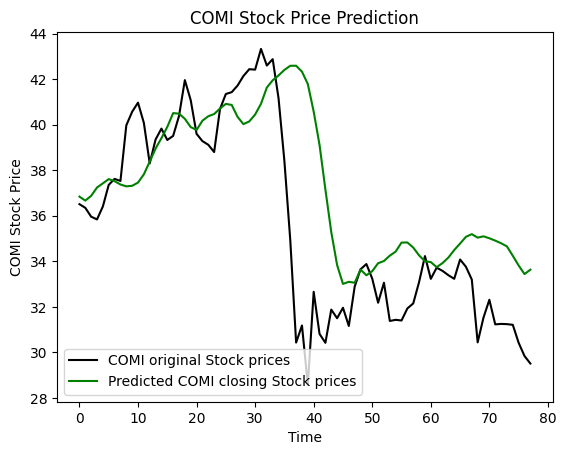

In [9]:
#La normalización funciona correctamente
plt.plot(precios_reales, color = 'black', label = 'COMI original Stock prices')
plt.plot(precios_predichos, color = 'green', label = 'Predicted COMI closing Stock prices')
plt.title('COMI Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('COMI Stock Price')
plt.legend()
plt.show()

In [11]:
# Guardar el modelo entrenado
# red.save('models/LSTM.h5')

In [12]:
# print(y_entrenamiento_n.size)
# plt.plot(y_entrenamiento_n)
# plt.show()

In [13]:
# ts_cierre_s_pred = c_entrenamiento_n

# loss_m = []
# for epoch in range(100):  # Número de épocas
#     ts_cierre_s_pred = c_entrenamiento_n[:time_steps]#se obtienen los primeros time_steps(8) elementos del trainig set
#     loss = []
#     X_train_c_pred = []
#     # print(f"grtrt: {ts_cierre_s_pred}")
#     for i in range(time_steps, N):
#         # Obtener las características y la etiqueta actual
#         x_actual = ts_cierre_s_pred[i-time_steps:i,0]
#         X_train_c_pred.append(x_actual)
#         x_actual = x_actual.reshape(1,time_steps,1)

#         y_actual = np.array([y_entrenamiento_n[i-time_steps]])

#         print(f"x_actual: {x_actual}")
#         print(f"y_actual: {y_actual}")
        
#         # Entrenar el modelo con las nuevas características y la etiqueta real
#         #loss.append(red.train_on_batch(x_actual, y_actual))

#         # Predicción del modelo
#         #prediccion = red.predict(x_actual)#.reshape(1,1,1)
#         prediccion = red(x_actual)
        
#         # Agregar la predicción a las características para el siguiente paso
#         # print(ts_cierre_s_pred)
#         print(f"prediccion: {prediccion}")
#         ts_cierre_s_pred = np.concatenate([ts_cierre_s_pred, prediccion])



#     # print(f"mean: {np.mean(np.array(loss))}")
#     # loss_m.append(np.mean(np.array(loss)))
#     X_train_c_pred = np.array(X_train_c_pred)
#     X_train_c_pred = np.reshape(X_train_c_pred, (X_train_c_pred.shape[0], X_train_c_pred.shape[1], 1))
#     history = red.fit(X_train_c_pred, y_entrenamiento_n, epochs=1, batch_size=32)
#     loss = history.history['loss']
#     loss_m.append(loss)
#     loss_m.append(mean_squared_error(c_entrenamiento_n,ts_cierre_s_pred[:,0]))

In [14]:
import src.modelos.LSTM.entrenamientos as entrena_lstm
entrena_lstm.entrena(red,c_entrenamiento_n,y_entrenamiento_n,8)

# red.save('redes/DWT_LSTM/auto_predictiva/LSTM_prueba')
# red = load_model('redes/DWT_LSTM/auto_predictiva/LSTM_ap_SGD_lr0.01_e10_bs1_df05.h5')

y_entrenamiento: [0.04610616 0.10422317 0.1542038  0.15575358 0.12553274 0.14567997
 0.14645486 0.19604804 0.2305308  0.20844634 0.21193336 0.207284
 0.19294847 0.19682294 0.21425804 0.18132507 0.17512592 0.14800465
 0.15885316 0.19217358 0.18597443 0.26695079 0.29252228 0.31770632
 0.31266951 0.28903526 0.28283611 0.29949632 0.27586207 0.27469973
 0.27547462 0.33475397 0.35567609 0.3366912  0.33359163 0.3847346
 0.57109647 0.59628051 0.57458349 0.60635413 0.58465711 0.56877179
 0.64277412 0.66175901 0.67299496 0.7105773  0.7039907  0.7272375
 0.72258814 0.77179388 0.72452538 0.67105773 0.67376986 0.71445176
 0.74389771 0.72258814 0.69934134 0.73731112 0.7214258  0.71871368
 0.6741573  0.69856645 0.72103836 0.72258814 0.75629601 0.82758621
 0.83882216 0.79426579 0.78380473 0.76791941 0.78457962 0.87872917
 0.8756296  0.84889578 0.81828749 0.82681131 0.78535451 0.78922898
 0.8341728  0.81247578 0.80123983 0.80317706 0.7934909  0.76017048
 0.73537389 0.71018985 0.71212708 0.7396358  0.73

[0.14400068510214092,
 0.1429960155831332,
 0.1465372722408557,
 0.1547590172336768,
 0.15723937985630604,
 0.15853740260568555,
 0.16502708278923658,
 0.16284197557120933,
 0.16286658361842465,
 0.1675762241267136]

In [ ]:
# print(loss_m)
# plt.plot(range(len(loss_m)),loss_m)
# plt.show()
# losses = history.history['loss']
# print(losses)
# plt.plot(range(len(losses)),losses)
# plt.show()
print(red.layers)


[<keras.src.layers.rnn.lstm.LSTM object at 0x000002112F202B50>, <keras.src.layers.regularization.dropout.Dropout object at 0x000002112EEB8050>, <keras.src.layers.rnn.lstm.LSTM object at 0x000002112F2B7FD0>, <keras.src.layers.regularization.dropout.Dropout object at 0x000002112F201310>, <keras.src.layers.rnn.lstm.LSTM object at 0x000002112E10A990>, <keras.src.layers.regularization.dropout.Dropout object at 0x000002112F2ECB50>, <keras.src.layers.rnn.lstm.LSTM object at 0x000002112F291710>, <keras.src.layers.regularization.dropout.Dropout object at 0x000002112F292210>, <keras.src.layers.core.dense.Dense object at 0x000002112F21D8D0>]


1/1 [==============================] - 0s 17ms/step


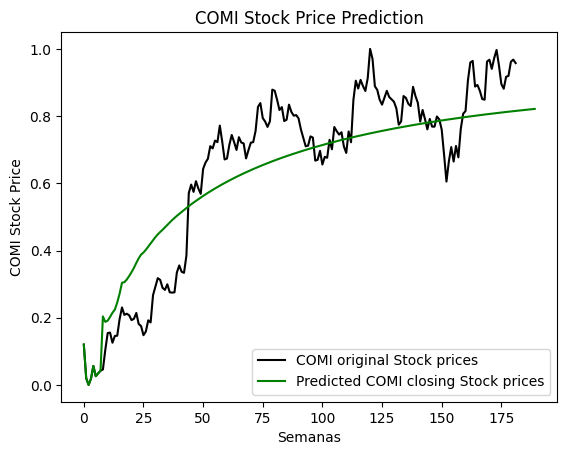

In [ ]:
# Predice el conjunto de entrenamiento usando la prediccion predictiva a partir de los primeros (usando los datos que predice)
red_ap_X_entrenamiento_n = c_entrenamiento_n[:time_steps].reshape(8)
red_ap_precios_predichos_n = utls.genera_prediccion_predictiva(red_ap_X_entrenamiento_n,8,182,red)

#Sin normalizar
plt.plot(c_entrenamiento_n, color = 'black', label = 'COMI original Stock prices')
plt.plot(red_ap_precios_predichos_n, color = 'green', label = 'Predicted COMI closing Stock prices') #ts_cierre_s_pred[:,0]
plt.title('COMI Stock Price Prediction')
plt.xlabel('Semanas')
plt.ylabel('COMI Stock Price')
plt.legend()
plt.show()

1/1 [==============================] - 0s 17ms/step


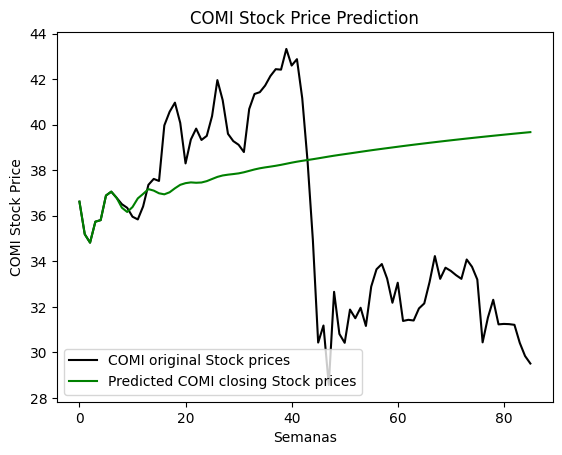

In [ ]:
# Ahora, el modelo ha sido entrenado de manera iterativa

red_ap_X_prueba_n = np.reshape(X_prueba_n[0,:], (1, X_prueba_n[0,:].shape[0], 1))
red_ap_precios_predichos = red.predict(red_ap_X_prueba_n)
f_predicted_sp_cierre = m_m_s.inverse_transform(red_ap_precios_predichos)

# Predice el conjunto de prueba usando la prediccion predictiva (ñps datos que va prediciendo)

red_ap_precios_predichos = utls.genera_prediccion_predictiva(red_ap_X_prueba_n.reshape(8),8,78,red)
temp = red_ap_precios_predichos
red_ap_precios_predichos = m_m_s_prueba.inverse_transform(red_ap_precios_predichos.reshape(86,1))

#Sin normalizar
plt.plot(m_m_s_prueba.inverse_transform(c_prueba_n), color = 'black', label = 'COMI original Stock prices') #c_prueba_n
plt.plot(red_ap_precios_predichos, color = 'green', label = 'Predicted COMI closing Stock prices')
plt.title('COMI Stock Price Prediction')
plt.xlabel('Semanas')
plt.ylabel('COMI Stock Price')
plt.legend()
plt.show()